In [18]:
import pypelines.ts_forecast_pipeline as pipe
from pypelines import utils
import pandas as pd
airline = pd.read_csv("pypelines/datasets/timeseries_forecast/airline.csv")
#longley = pd.read_csv("pypelines/datasets/timeseries_forecast/longley.csv")
airline.columns

Index(['Date', 'Passengers'], dtype='object')

In [25]:
tsf = pipe.TSForecastPipeline(data = "airline",models=['ARIMA', 'Trend Forecast'],
                 date_column = 'Date',
                 date_format = "%Y-%m",
                 target_column = 'Passengers',
                 frequency = "M",
                 forecast_horizon = [row for row in range(1,10)])

In [26]:
tsf.code_to_clipboard()

Fitting 126 folds for each of 1 candidates, totalling 126 fits


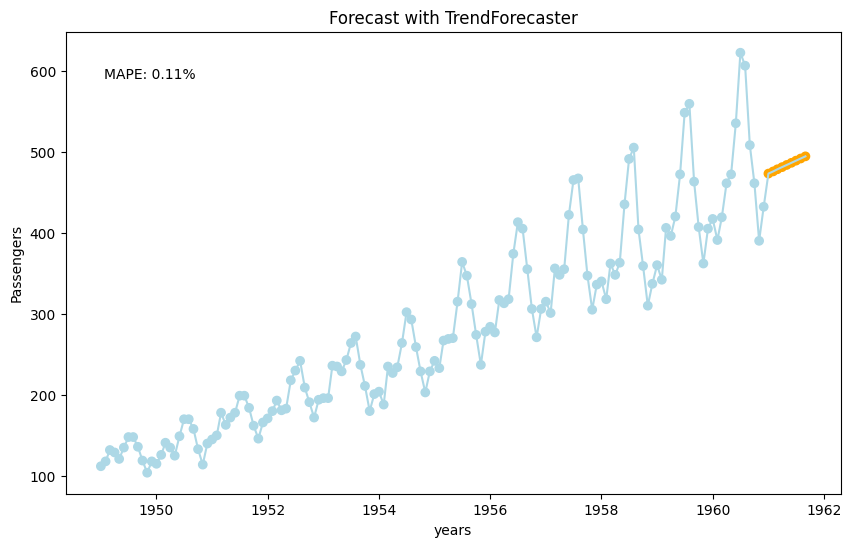

Fitting 126 folds for each of 1 candidates, totalling 126 fits


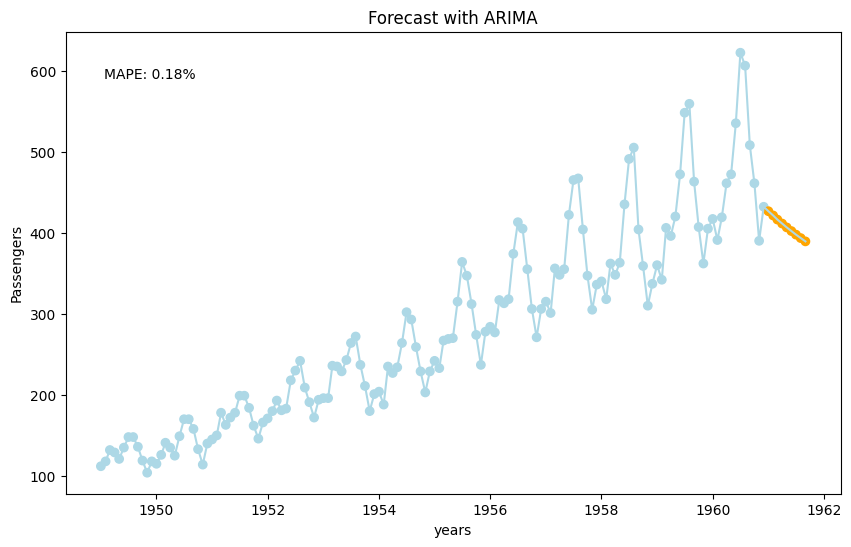

   mean_test_MeanAbsolutePercentageError  mean_fit_time  mean_pred_time   
0                               0.113851       0.006265        0.004312  \
0                               0.178558       0.154188        0.031220   

  params  rank_test_MeanAbsolutePercentageError   
0     {}                                    1.0  \
0     {}                                    1.0   

                                               model  
0  <class 'sktime.forecasting.trend.TrendForecast...  
0           <class 'sktime.forecasting.arima.ARIMA'>  
The best model is <class 'sktime.forecasting.trend.TrendForecaster'> with MAPE of 0.113851 % and predict time of 0.004312


In [28]:

from sktime import *
from sklearn.metrics import mean_squared_error


import pandas as pd
import numpy as np

target_col='Passengers'
date_col = 'Date'


y = airline[[date_col,target_col]]
y_train_preprocessed = y
y_train_preprocessed[date_col] = pd.to_datetime(y_train_preprocessed[date_col],format = "%Y-%m")
y_train_preprocessed = y_train_preprocessed.set_index(date_col)
y_train_preprocessed.index = y_train_preprocessed.index.to_period(freq = "M")

model_comparison_list = []

##### End of Data Processing Pipeline #####


##### Model Pipeline for Trend Forecast #####

from sktime.forecasting.trend import TrendForecaster
from sktime.forecasting.model_selection import ExpandingWindowSplitter,ForecastingGridSearchCV,ExpandingWindowSplitter
from sklearn.metrics import mean_squared_error,make_scorer,r2_score,explained_variance_score
import matplotlib.pyplot as plt
cv = ExpandingWindowSplitter(fh=[1, 2, 3, 4, 5, 6, 7, 8, 9])

TrendForecaster_param_grid = {
}


TrendForecaster_model = TrendForecaster()

TrendForecaster_gscv = ForecastingGridSearchCV(
    forecaster=TrendForecaster_model,
    param_grid=TrendForecaster_param_grid,
    cv=cv,
    verbose=1)
TrendForecaster_gscv.fit(y_train_preprocessed)
TrendForecaster_performance_metrics = TrendForecaster_gscv.cv_results_
TrendForecaster_performance_metrics['model'] = TrendForecaster

model_comparison_list.append(TrendForecaster_performance_metrics)

# get the prediction on the test data
TrendForecaster_y_pred = TrendForecaster_gscv.predict(fh=[1, 2, 3, 4, 5, 6, 7, 8, 9])


TrendForecaster_val = pd.concat([y_train_preprocessed,TrendForecaster_y_pred])
TrendForecaster_val = TrendForecaster_val.reset_index()

# Example time series data
TrendForecaster_timestamps = TrendForecaster_val['index'].astype(str)  # List or array of timestamps
TrendForecaster_values = TrendForecaster_val[f'{target_col}']  # List or array of corresponding values

# Example two time points to differentiate
start_time = np.datetime64(y_train_preprocessed.reset_index()['Date'].astype(str)[0])
end_time = np.datetime64(y_train_preprocessed.reset_index()['Date'].astype(str)[143])

# Convert timestamps to datetime objects
TrendForecaster_timestamps = [np.datetime64(ts) for ts in TrendForecaster_timestamps]
TrendForecaster_mape = TrendForecaster_gscv.cv_results_['mean_test_MeanAbsolutePercentageError']
mape = TrendForecaster_mape.to_list()[0]

# Create color list for segments
colors = ['lightblue' if (start_time <= ts <= end_time) else 'orange' for ts in TrendForecaster_timestamps]

# Plot the time series with differentiated colors
plt.figure(figsize=(10, 6))
plt.plot(TrendForecaster_timestamps, TrendForecaster_values, color='lightblue')
plt.scatter(TrendForecaster_timestamps, TrendForecaster_values, color=colors)
plt.xlabel('years')
plt.ylabel(f'{target_col}')
plt.title(f'Forecast with TrendForecaster')
plt.annotate(f'MAPE: {mape:.2f}%', xy=(0.05, 0.9), xycoords='axes fraction')
plt.show()

##### End of Model Pipeline for Trend Forecast #####
##### Model Pipeline for ARIMA #####

from sktime.forecasting.arima  import ARIMA
from sktime.forecasting.model_selection import ExpandingWindowSplitter,ForecastingGridSearchCV,ExpandingWindowSplitter
from sklearn.metrics import mean_squared_error,make_scorer,r2_score,explained_variance_score
import matplotlib.pyplot as plt
cv = ExpandingWindowSplitter(fh=[1, 2, 3, 4, 5, 6, 7, 8, 9])

ARIMA_param_grid = {
}


ARIMA_model = ARIMA()

ARIMA_gscv = ForecastingGridSearchCV(
    forecaster=ARIMA_model,
    param_grid=ARIMA_param_grid,
    cv=cv,
    verbose=1)
ARIMA_gscv.fit(y_train_preprocessed)
ARIMA_performance_metrics = ARIMA_gscv.cv_results_
ARIMA_performance_metrics['model'] = ARIMA

model_comparison_list.append(ARIMA_performance_metrics)

# get the prediction on the test data
ARIMA_y_pred = ARIMA_gscv.predict(fh=[1, 2, 3, 4, 5, 6, 7, 8, 9])


ARIMA_val = pd.concat([y_train_preprocessed,ARIMA_y_pred])
ARIMA_val = ARIMA_val.reset_index()

# Example time series data
ARIMA_timestamps = ARIMA_val['index'].astype(str)  # List or array of timestamps
ARIMA_values = ARIMA_val[f'{target_col}']  # List or array of corresponding values

# Example two time points to differentiate
start_time = np.datetime64(y_train_preprocessed.reset_index()['Date'].astype(str)[0])
end_time = np.datetime64(y_train_preprocessed.reset_index()['Date'].astype(str)[143])

# Convert timestamps to datetime objects
ARIMA_timestamps = [np.datetime64(ts) for ts in ARIMA_timestamps]
ARIMA_mape = ARIMA_gscv.cv_results_['mean_test_MeanAbsolutePercentageError']
mape = ARIMA_mape.to_list()[0]

# Create color list for segments
colors = ['lightblue' if (start_time <= ts <= end_time) else 'orange' for ts in ARIMA_timestamps]

# Plot the time series with differentiated colors
plt.figure(figsize=(10, 6))
plt.plot(ARIMA_timestamps, ARIMA_values, color='lightblue')
plt.scatter(ARIMA_timestamps, ARIMA_values, color=colors)
plt.xlabel('years')
plt.ylabel(f'{target_col}')
plt.title(f'Forecast with ARIMA')
plt.annotate(f'MAPE: {mape:.2f}%', xy=(0.05, 0.9), xycoords='axes fraction')
plt.show()

##### End of Model Pipeline for ARIMA #####
##### Model Comparison #####
table = pd.concat(model_comparison_list)
table = table.sort_values('mean_test_MeanAbsolutePercentageError', ascending=True)
print(table)
print(f"The best model is {table['model'].iloc[0]} with MAPE of {table['mean_test_MeanAbsolutePercentageError'].iloc[0]:1f} % and predict time of {table['mean_pred_time'].iloc[0]:1f}")

